# 프로젝트: CIFAR10 모델을 튜닝하고 배포하기!
## 개요
이번 프로젝트에서는 배운 프로젝트중에서 CIFAR10 프로젝트를 기반으로 데이터를 수정하고 하이퍼파라미터 튜닝을 한 다음 배포합니다.

## 목차
0. 모델 고정해서 사용하기
1. Data Centric AI 맛보기
2. 하이퍼파라미터 튜닝

## 회고

## Reference
---

In [1]:
# 주요 라이브러리 버전 확인

import tensorflow

print(tensorflow.__version__)

2.6.0


## 작업환경 구성하기

In [2]:
# 패키지 불러오기
import os     # 운영 체제와 상호 작용하기 위한 os 모듈
import glob   # 파일 경로에 대한 패턴 매칭을 위한 glob 모듈
import time   # 시간과 관련된 기능을 사용하기 위한 time 모듈

import PIL          # 이미지 처리를 위한 Python Imaging Library인 PIL(Pillow)
import imageio      # 이미지 입출력을 위한 imageio 모듈
import numpy as np  # 다차원 배열 및 수학적 연산을 위한 NumPy 라이브러리
import tensorflow as tf
from tensorflow.keras import layers    # TensorFlow의 Keras API에서 층을 정의하는 데 사용되는 layers 모듈
from IPython import display            # IPython의 display 모듈에서 display 함수. 주로 이미지나 동적인 콘텐츠를 출력하기 위해 사용
import matplotlib.pyplot as plt        # 데이터 시각화를 위한 Matplotlib 라이브러리에서 pyplot 모듈
%matplotlib inline
# IPython 환경에서 Matplotlib의 그림을 인라인으로 표시하도록 하는 IPython 매직 명령어

print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


## 0. 모델 고정해서 사용하기
이번 CIFAR10 프로젝트의 경우에는 모델을 고정해서 사용할 예정입니다. 모델의 경우에는 다음과 같은 그림으로 구성합니다!
![모델](https://d3s0tskafalll9.cloudfront.net/media/images/Screenshot_from_2024-01-25_12-03-51.max-800x600.png)

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout

In [5]:
# 모델 구성하기
model = tf.keras.Sequential()

model.add(layers.Input(shape=(30, 30, 3)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(AveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(layers.BatchNormalization())
model.add(Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

## 데이터셋 구성하기

In [6]:
# 데이터셋 불러오기

cifar10 = tf.keras.datasets.cifar10

(train_x, train_y), (test_x, test_y) = cifar10.load_data()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [8]:
# label 변환 - categorical을 활용하여 MNIST 데이터셋의 레이블을 원-핫 인코딩(one-hot encoding)으로 변환
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [11]:
# 픽셀 값 정규화 : -1에서 1사이의 값으로
train_x = (train_x - 127.5) / 127.5
test_x = (test_x - 127.5) / 127.5

print('최소값:',np.min(train_x), ' 최대값:',np.max(test_x))

최소값: -1.0  최대값: 1.0


# 1. Data Centric AI 맛보기
Data Centric AI를 정석적으로 진행한다면 훈련 데이터셋과 테스트 데이터셋을 전부 열어서 확인해서 틀린 것이 없는지 검수해야 합니다.   
하지만 일일이 해볼만한 시간은 존재하지 않으니 사람들이 미리 검수했던 내용들을 기반으로 프로젝트를 진행하겠습니다.   
- [labelerrors.com](https://labelerrors.com/)

labelerrors.com은 Data Centric AI에서 가장 많이 활용하고 있는 파이썬 라이브러리인 cleanlab을 만든 개발자들이 공개한 사이트입니다.   
labelerrors.com은 이름에서 알 수 있듯이 테스트 데이터와 label이 잘못 붙어 있는 사례를 모아 보여줍니다.  
labelerrors.com에서 CIFAR10 테스트 데이터셋을 확인하고 아래 조그맣게 있는 ID를 기준으로 직접 데이터셋을 시각화하고 실제 label이 잘못 붙어있다면 label을 수정합니다.

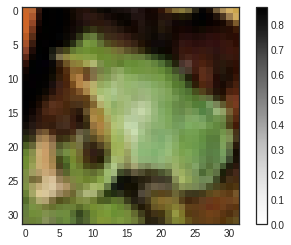

In [21]:
plt.style.use('seaborn-white')

plt.figure()
plt.imshow((test_x[2405]*127.5 + 127.5)/255)
plt.colorbar()
plt.show()

In [26]:
# class_names 리스트 변수 만들기

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [30]:
# 잘못된 라벨 수정

test_y[2405]=6
test_y[6877]=8
test_y[8058]=7
test_y[2532]=0
test_y[7657]=7
test_y[1969]=9
test_y[2804]=5
test_y[6792]=3
test_y[1227]=5
test_y[5191]=5
test_y[5690]=4
test_y[1718]=8
test_y[2592]=4
test_y[4794]=2
test_y[5960]=3
test_y[165]=4
test_y[9227]=9
test_y[5632]=5
test_y[9352]=9
test_y[7846]=3
test_y[6966]=8
test_y[5468]=3

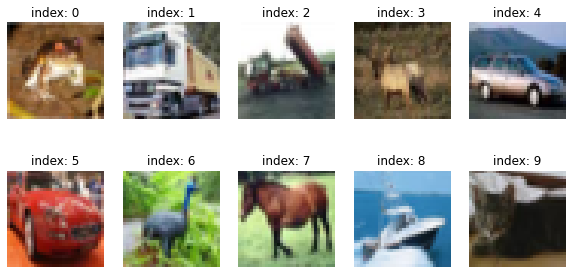

In [10]:
# 10개 데이터 한 번에 확인하기 - for문 활용

plt.figure(figsize=(10, 5))   # 이미지의 전체 프레임의 크기를 결정

for i in range(10):
    plt.subplot(2, 5, i+1)   # 여러 개의 이미지를 한 번에 띄우고 싶을 때에는 plt.subplot(row, col, index)의 형태로 확인
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [15]:
# train data와 validation data 80:20으로 나누기 (: )scikit-learn에 내장되어 있는 train_test_split 활용)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.2)

# 훈련, 검증 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 10)
(10000, 10)


# 2. 하이퍼파라미터 튜닝
위에 있는 모델을 기반으로 KerasTuner로 하이퍼파라미터 튜닝을 진행합니다.   
튜닝한 하이퍼 파라미터로 학습을 진행하고 모델을 SavedModel 형식으로 저장합니다.  

(주의사항)
하이퍼 파라미터를 어느정도 범위로 주는지에 따라서 모델 튜닝속도가 달라집니다.  
학습시간을 고려해서 하이퍼 파라미터 튜닝을 세팅해주세요!  

**DeepTuner는**  
- kerastuner.Tuner를 인자로 하는 class이며 
- class에서 수행하는 함수는 run_trial, save_model load_model입니다.

**run_trial 함수에서 제일 중요한 부분은 hypermodel과 trial**입니다.  
- KerasTuner에서의 hypermodel : 모델을 공유 및 재사용하기 위해 검색 공간을 캡슐화하는 모델입니다. 
    - hypermodel의 경우 hp라는 인수를 활용해서 keras.Model을 생성합니다.
    - 즉 hypermodel은 우리가 만들고 싶은 모델을 쌓는 과정을 거치는데 이때 하이퍼파라미터 튜닝에 대한 검색공간을 만들어줄때 hp라는 인수를 사용해서 만든 모델입니다.
    - build 메소드 : 모델이 빌드가 되면서 하이퍼파라미터 튜닝이 시작합니다.
        
- trial : Oracle에 속하는 class입니다.
    - Oracle이란 KerasTuner의 모든 검색 알고리즘에서 사용하는 기본 클래스이며 크게 RandomSearchOracle, BayesianOptimizationOracle, HyperbandOracle이 있습니다.
    - 쉽게 설명하면 Oracle은 KerasTuner가 하이퍼파라미터를 정할 때 사용하는 알고리즘!
    - 여기서 trial.hyperparameter는 Oracle이 찾아야 하는 하이퍼파라미터입니다. 즉 hypermodel에서의 hp입니다.
    - 여기서는 model.fit()을 할때 batch_size도 고를 수 있게 만들었습니다.

In [17]:
# DeepTuner class 생성

import kerastuner as kt

class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        # hypermodel을 사용하여 모델 아키텍처를 구성
        model = self.hypermodel.build(trial.hyperparameters)
        
        # batch_size 하이퍼파라미터를 실험의 선택(16 또는 32)에 따라 동적으로 설정
        # 훈련 프로세스를 구성하기 위한 추가 키워드 인수 (fit_kwargs)를 허용
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        
        # 검증 평가에서 모델의 메트릭과 해당 값을 포함하는 사전을 반환. 실험의 성능을 평가하고 하이퍼파라미터 검색 프로세스를 안내하는 데 사용
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

ModuleNotFoundError: No module named 'kerastuner'

In [18]:
!pip install keras-tuner

     |████████████████████████████████| 128 kB 5.5 MB/s            


In [20]:
# DeepTuner class 생성

import keras_tuner as kt

class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        # hypermodel을 사용하여 모델 아키텍처를 구성
        model = self.hypermodel.build(trial.hyperparameters)
        
        # batch_size 하이퍼파라미터를 실험의 선택(16 또는 32)에 따라 동적으로 설정
        # 훈련 프로세스를 구성하기 위한 추가 키워드 인수 (fit_kwargs)를 허용
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        
        # 검증 평가에서 모델의 메트릭과 해당 값을 포함하는 사전을 반환. 실험의 성능을 평가하고 하이퍼파라미터 검색 프로세스를 안내하는 데 사용
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

## build_model 살펴보기
build_model은 hypermodel을 만들어줘야 합니다. 여기서 만든 hypermodel은 총 2가지 기법이 들어가 있으며 주의사항도 1가지 있습니다.

### 주의사항
- 해당 모델의 경우 hypermodel이기 때문에 Input지정이 필수입니다! 그렇기에 넣고 싶은 모델에 대한 shape을 꼭 기재해야 합니다!

### 기법
- 첫번째 기법은 바로 layer의 숫자도 KerasTuner에게 맡겼습니다.  
for문을 확인해보겠습니다.  
    - 첫번째 for문의 경우 hp.Int로 만들어 검색공간은 정수로 만들고 가장 작은값을 1로 가장 큰값을 10으로 두었습니다.  
    이렇게 설정하면 최소 1개에서 최소 10개의 layer를 쌓을 수 있게 설정할 수 있습니다.   
    제가 쌓고싶은 layer는 conv2D인데 kernel_size는 (3,3)이며 차원수는 최소 32에서 최대 256으로 바꾸었습니다.

    - 두번째 for문도 최소 1개에서 3개로 설정했지만 Dense Layer의 경우 나올 수 있는 차원을 32,64,128,256중 1개를 선택하도록 만들었습니다.

이러한 방식으로 hypermodel을 만들면 하고싶은 하이퍼 파라미터 튜닝을 진행할 수 있습니다.

In [36]:
# # 참고용 - build_model 함수 구현

# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     # input layer
#     model.add(tf.keras.Input(shape = X_train.shape[1:], name = 'inputs'))
    
#     # Conv layer
#     for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
#               model.add(tf.keras.layers.Conv2D(hp.Int(
#                   'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3), activation='relu'))
    
#     # Flatten layer
#     model.add(tf.keras.layers.Flatten())
#     for i in range(hp.Int('n_connections', 1, 3)):
#         model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
#                                   values=[32,64,128,256]), activation = 'relu'))
        
#     model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
    
#     model.compile(optimizer = 'adam',loss='categorical_crossentropy',
#         metrics=['accuracy'])
    
#     return model

# # Input layer에서 shape = X_train.shape[1:]
# # X_train.shape은 (48000, 28, 28, 1)이므로 input layer shape은 28*28로 설정됨

# # Conv layer에서 for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
# # 하이퍼파라미터 'num_layers'에 지정된 횟수만큼 반복하며 컨볼루션 층을 추가. 
# # hp.Int('num_layers', min_value=1, max_value=10)는 컨볼루션 층의 개수를 1부터 10 사이의 정수로 설정한 것

# # hp.Int('units_{i}'.format(i=i), min_value=32, max_value=128, step=5): 컨볼루션 층의 필터 개수를 32부터 128까지 5의 간격으로 설정합니다.

# # Flatten layer에서
# # hp.Int('n_connections', 1, 3): Dense 층의 개수를 1부터 3 사이의 정수로 설정
# # hp.Choice(f'n_nodes', values=[32,64,128, 256]): Dense 층의 노드 개수를 32, 64, 128, 256 중에서 선택합니다.

In [49]:
# build_model 함수 구현

def build_model(hp):
    model = tf.keras.Sequential()
    
    # input layer
    model.add(tf.keras.Input(shape = X_train.shape[1:], name = 'inputs'))

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(AveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.2))) # <-- Added closing parenthesis here
        
    model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
    
    model.compile(optimizer = 'adam',loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

## keras_tuner를 정의하고 탐색하기

이번 모델의 경우 BayesianOptimizationOracle을 사용할 예정이며 목표는 accuracy와 max로 둘 예정입니다.   
실제 trial은 10번으로 지정할 것입니다.  

hypermodel은 build_model을 넣고 project이름도 작성합니다.  
마지막으로 search함수에 X_train, Y_train, validation data, epoch을 넣고 탐색합니다!

In [50]:
# keras_tuner 정의하기

# my_keras_tuner = DeepTuner(): DeepTuner 클래스의 객체를 생성
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

# objective=kt.Objective('accuracy', 'max'): 검증 데이터에서의 정확도를 최대화하는 목표를 설정
# max_trials=10: 최대 10개의 하이퍼파라미터 조합을 시도
# hypermodel=build_model(): 하이퍼파라미터 객체를 생성하는 함수를 지정
# overwrite=True: 이전 결과를 덮어쓰도록 설정


# 해당 모델 학습시간은 약 10분정도 걸립니다!
my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)

Trial 10 Complete [00h 00m 24s]
accuracy: 0.6909000277519226

Best accuracy So Far: 0.7250000238418579
Total elapsed time: 00h 03m 58s


### 가장 좋은 모델 확인하기
가장 좋은 모델을 뽑는 방법은 KerasTuner.get_best_hyperparamters를 이용해서 가장 좋은 하이퍼파라미터를 뽑아내는 작업입니다.  
하이퍼파라미터를 뽑았으면 build_model()에 집어넣어 가장 좋은 모델을 선언합니다.  

In [51]:
# best model 확인

best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

# my_keras_tuner.get_best_hyperparameters(num_trials=10): Keras Tuner 객체에서 상위 10개 실험의 최적 하이퍼파라미터 조합을 가져옵니다.
# [0]: 첫 번째 (가장 우수한) 하이퍼파라미터 조합을 추출하여 best_hps 변수에 저장합니다.

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
average_pooling2d_56 (Averag (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
average_pooling2d_57 (Averag (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
flatten_40 (Flatten)         (None, 3136)            

최고의 하이퍼 파라미터만 뽑았기 때문에 아직 모델학습이 되지 않았습니다!  
이번에 epoch을 5번 정도 주어서 모델학습을 진행합니다!  

만일 무거운 모델을 돌릴 경우 하이퍼파라미터 튜닝작업이 매우 느려질 수 있습니다.  
그때의 경우 하이퍼파라미터 튜닝할때 epoch을 3-4정도로 작게 주어 최고의 하이퍼파라미터를 뽑아낸 다음 본격적인 모델학습때 epoch을 넉넉하게 주는 것도 방법입니다

In [52]:
# model fit

model.fit(X_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1250/1250 [==============================] - 5s 3ms/step - loss: 1.4665 - accuracy: 0.5145
Epoch 2/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9731 - accuracy: 0.6570
Epoch 3/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7716 - accuracy: 0.7303
Epoch 4/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6108 - accuracy: 0.7850
Epoch 5/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4685 - accuracy: 0.8340


In [54]:
# model evaluate

model.evaluate(test_x, test_y)

313/313 [==============================] - 1s 3ms/step - loss: 1.7460 - accuracy: 0.7078


[1.7459994554519653, 0.7077999711036682]

## 모델 저장

우리가 이전까지 자주 사용한 저장방법은 HDF5파일 (.h5)로 저장하는 방법이었습니다.  
HDF파일로 저장하는 방식은 이전 Keras에서 모델을 저장하는 방식이었으나 사실 이 방법은 TensorFlow나 Keras에서 그다지 선호하지 않는 저장방식입니다.  
**TensorFlow의 경우 공식적으로 지원하는 모델 저장방식은 SavedModel**입니다.    

**SavedModel**은 .h5파일처럼 모델의 가중치와 모델을 전부 하나의 파일로 관리하는 방식이 아닌 **모델, 가중치를 따로 구분해서 저장하는 방식**입니다.  

SavedModel은 크게 3가지로 구성되어 있습니다.  
- saved_model.pb : pb는 프로토콜 버퍼를 의미하며 해당 파일은 **내보낸 모델 그래프 구조를 포함**하고 있습니다.
- variables : **내보낸 변수값이 있는 이진 파일과 내보낸 모델 그래프에 해당하는 체크포인트를 포함**하고 있습니다
- assets : 내보낸 모델을 불러올 때 **추가적인 파일이 필요한 경우 이 폴더에 파일이 생성**됩니다.  
이 방식으로 진행한다면 모델을 배포할 때 유리합니다.  

Keras의 경우 .keras파일을 선호합니다. **.keras파일은 .h5파일과 마찬가지로 가중치와 모델을 전부 하나의 파일로 관리**합니다.

In [55]:
# model save

save_path = os.getenv('HOME') + '/aiffel/mlops/best_model/project'
fname = os.path.join(save_path, 'model')
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/best_model/project/model/assets


---
## 회고
### KEEP
각 단계를 이해하면서 진행하려고 노력했다. 

### PROBLEM
- 각 단계의 함수 내용이 잘 정리되지 않고 어렵다.
- 노드에서 정해준 기준대로 모델의 shape 맞추는 것이 함수 내에서 구현은 어렵다. 

### TRY
- 라벨 수정 for문 등 간단히 표현하는 방법 찾아보기
- 각 단계의 함수 명확히 이해하기
- 모델의 shape 다시 맞춰보기